## 가공한 원본 데이터 확인

In [2]:
train = pd.read_csv("smart_farm_train.csv")
test = pd.read_csv("smart_farm_test.csv")

### ASOS 기상관측 데이터 추가 수집
- 데이터 추가 수집
- 위도 : 35.16378 경도 : 128.04004
- 35.16378,128.04004

In [1]:
import pandas as pd
import glob, os
import warnings
warnings.filterwarnings("ignore")
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
import seaborn as sns
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings("ignore")

In [4]:
input_file = r'C:\Users\kimy\smart_farm\ASOS' 

all_file_list = glob.glob(os.path.join(input_file, 'SURFACE*'))
all_data = []

for file in all_file_list:
    df = pd.read_csv(file,encoding="cp949")
    all_data.append(df)

In [204]:
data = pd.concat(all_data, axis=0, ignore_index=True)
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
# 중복제거까지

이미 데이터가 일부 존재하기에 현지기압/해면기압/일조/누적강수량 사용

In [205]:
data.columns = ["지점","시간","기온","누적강수량","풍향","풍속","현지기압","해면기압","습도","일사","일조"]
data.drop(["기온","풍속","풍향","습도","일사"],axis=1,inplace = True)

In [206]:
data["시간"] = data["시간"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d %H:%M'))

In [207]:
data.isnull().sum()

지점          0
시간          0
누적강수량    1559
현지기압        0
해면기압        0
일조          1
dtype: int64

In [208]:
data[data["시간"] == "2021-11-29 04:03:00"]

,지점,시간,누적강수량,현지기압,해면기압,일조
40542,192,2021-11-29 04:03:00,0.0,1026.8,1030.6,0.0


#### 학습,예측용 데이터의 시간과 매핑해보기

In [73]:
from datetime import datetime

In [74]:
train = pd.read_csv("smart_farm_train.csv")
test = pd.read_csv("smart_farm_test.csv")

In [75]:
print(train.shape)
print(test.shape)

(130886, 25)
(18720, 25)


In [76]:
train["시간"] = train["시간"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d %H:%M'))
test["시간"] = test["시간"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [83]:
train_test = pd.concat([train,test],axis=0,ignore_index=True)

In [78]:
# train_test.iloc[:110908,:] 학습용 데이터
# train_test.iloc[110908:,:]

#### 데이터 이상치 해결하기
- 일사량 이상치 제거하기

In [85]:
train_test["일사량(W/㎡)"].describe()

count    149606.000000
mean        142.807337
std         222.885628
min          -5.500000
25%          -3.300000
50%          -2.300000
75%         260.000000
max        1144.000000
Name: 일사량(W/㎡), dtype: float64

In [86]:
train_test["일사량(W/㎡)"] = train_test["일사량(W/㎡)"].apply(lambda x : 0 if x < 0 else x)

In [88]:
train_test["일사량(W/㎡)"].describe()

count    149606.000000
mean        144.563647
std         221.737451
min           0.000000
25%           0.000000
50%           0.000000
75%         260.000000
max        1144.000000
Name: 일사량(W/㎡), dtype: float64

추가로 수집한 데이터와 연결하기

In [215]:
train_test_merge = pd.merge(train_test,data,on="시간",how="left")
train_test_merge

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),지점,누적강수량,현지기압,해면기압,일조
0,2021-11-26 00:00:00,2021-11-26 00:00:00,2021,11,26,0,0,-2.7,5.8,67,...,1.0,0.0,28.0,18.0,0.9,192.0,0.0,1018.2,1021.9,29180.0
1,2021-11-26 00:01:00,2021-11-26 00:00:00,2021,11,26,0,1,-2.9,5.8,67,...,1.0,0.0,28.0,18.0,0.9,192.0,0.0,1018.2,1021.9,0.0
2,2021-11-26 00:02:00,2021-11-26 00:00:00,2021,11,26,0,2,-3.0,5.7,67,...,1.0,1.0,28.0,18.0,0.9,192.0,0.0,1018.1,1021.8,0.0
3,2021-11-26 00:03:00,2021-11-26 00:00:00,2021,11,26,0,3,-3.0,5.7,67,...,1.0,1.0,28.0,18.0,0.8,192.0,0.0,1018.1,1021.8,0.0
4,2021-11-26 00:04:00,2021-11-26 00:00:00,2021,11,26,0,4,-2.8,5.7,67,...,1.0,1.0,28.0,18.0,1.0,192.0,0.0,1018.1,1021.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131063,2022-01-29 23:55:00,2022-01-29 00:00:00,2022,1,29,23,55,-2.1,1.7,33,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1016.7,1020.4,27581.0
131064,2022-01-29 23:56:00,2022-01-29 00:00:00,2022,1,29,23,56,-2.2,1.7,33,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1016.7,1020.4,27581.0
131065,2022-01-29 23:57:00,2022-01-29 00:00:00,2022,1,29,23,57,-2.3,1.7,33,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1016.6,1020.3,27581.0
131066,2022-01-29 23:58:00,2022-01-29 00:00:00,2022,1,29,23,58,-2.3,1.6,33,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1016.6,1020.3,27581.0


일조량 데이터의 그래프 확인

<AxesSubplot:xlabel='시간'>

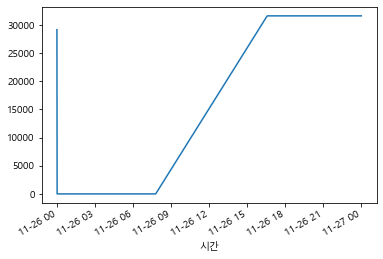

In [216]:
train_test_merge[train_test_merge["년월일"] == "2021-11-26 00:00:00"].set_index("시간")["일조"].plot()

결합한 데이터에 대해서 결측치 확인
- 일부 시간대의 경우 지점에서 결측치가 발생함
- 11월 29일 새벽 4시 0분 ,1분, 2분, 3분 중에서 2분이 결측치인 상태
- 지점~일조까지는 앞뒤 평균으로 해결하기

In [217]:
def get_결측치(data):
    
    측정목록 = ['지점','내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)',
       '에너지스크린(수평)', '에너지스크린(수직)', '배기팬', '천창', '유동팬', '팬코일 B동',
                   '환기온도(천창 제어온도)', '난방온도(설정온도)','누적강수량', '현지기압','해면기압', '일조']
    결과리스트 = []

    # 데이터프레임 copy하기
    df = data.copy()
    
    for 항목 in 측정목록:
        for idx,row in df[df[항목].isnull()].iterrows():
            
            if df.loc[idx+1,항목] != np.nan:
                
                if df.loc[idx-1,항목] != np.nan:
                    
                    df.loc[idx,항목] = ( df.loc[idx+1,항목]+df.loc[idx-1,항목] ) / 2
                    
    결과리스트.append(df)
    
    return pd.concat(결과리스트,axis=0,ignore_index = False)

In [218]:
train_test_merge.isnull().sum()

시간                   0
년월일                  0
년도                   0
월                    0
일                    0
시                    0
분                    0
일사량(W/㎡)             0
외기온(℃)               0
외기습도(%)              0
풍속(m/s)              0
풍향(º)                0
내부 온도               15
내부 습도               15
차광스크린(수평)           15
차열스크린(수평)           15
에너지스크린(수평)          15
에너지스크린(수직)          15
배기팬                 15
천창                  15
유동팬                 15
팬코일 B동              15
환기온도(천창 제어온도)       16
난방온도(설정온도)          16
열공급량(kWh)        20160
지점                1414
누적강수량             1978
현지기압              1414
해면기압              1414
일조                1415
dtype: int64

In [219]:
train_test_merge[train_test_merge["지점"].isnull()]

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),지점,누적강수량,현지기압,해면기압,일조
4473,2021-11-29 04:02:00,2021-11-29 00:00:00,2021,11,29,4,2,-3.9,-0.3,90,...,1.0,1.0,28.0,18.0,0.8,NaN,NaN,NaN,NaN,NaN
5093,2021-11-29 14:23:00,2021-11-29 00:00:00,2021,11,29,14,23,434.0,16.1,30,...,1.0,0.0,30.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN
8300,2021-12-01 22:03:00,2021-12-01 00:00:00,2021,12,1,22,3,-3.1,1.0,46,...,1.0,1.0,28.0,18.0,0.2,NaN,NaN,NaN,NaN,NaN
12256,2021-12-04 16:01:00,2021-12-04 00:00:00,2021,12,4,16,1,154.0,10.2,44,...,1.0,1.0,30.0,20.0,0.1,NaN,NaN,NaN,NaN,NaN
25026,2021-12-13 13:02:00,2021-12-13 00:00:00,2021,12,13,13,2,572.0,7.4,21,...,1.0,0.0,30.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124071,2022-01-25 03:23:00,2022-01-25 00:00:00,2022,1,25,3,23,-2.8,1.7,73,...,1.0,0.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
124780,2022-01-25 15:12:00,2022-01-25 00:00:00,2022,1,25,15,12,122.0,8.4,56,...,1.0,1.0,30.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
126509,2022-01-26 20:01:00,2022-01-26 00:00:00,2022,1,26,20,1,-3.1,3.6,56,...,1.0,0.0,28.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
128734,2022-01-28 09:06:00,2022-01-28 00:00:00,2022,1,28,9,6,352.0,2.6,35,...,1.0,1.0,27.0,20.1,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
data.iloc[40540:40545,:]

,지점,시간,누적강수량,현지기압,해면기압,일조
40540,192,2021-11-29 04:00:00,0.0,1026.8,1030.6,0.0
40541,192,2021-11-29 04:01:00,0.0,1026.8,1030.6,0.0
40542,192,2021-11-29 04:03:00,0.0,1026.8,1030.6,0.0
40543,192,2021-11-29 04:04:00,0.0,1026.8,1030.6,0.0
40544,192,2021-11-29 04:05:00,0.0,1026.8,1030.6,0.0


In [221]:
train_test_merge = get_결측치(train_test_merge)

In [222]:
train_test_merge.isnull().sum()
# 여전히 1386개 정도의 결측 존재

시간                   0
년월일                  0
년도                   0
월                    0
일                    0
시                    0
분                    0
일사량(W/㎡)             0
외기온(℃)               0
외기습도(%)              0
풍속(m/s)              0
풍향(º)                0
내부 온도               12
내부 습도               12
차광스크린(수평)           12
차열스크린(수평)           12
에너지스크린(수평)          12
에너지스크린(수직)          12
배기팬                 12
천창                  12
유동팬                 12
팬코일 B동              12
환기온도(천창 제어온도)       12
난방온도(설정온도)          12
열공급량(kWh)        20160
지점                1386
누적강수량             1950
현지기압              1386
해면기압              1386
일조                1386
dtype: int64

In [240]:
train_test_merge[train_test_merge["지점"].isnull()]["년월일"].value_counts()

2021-12-31 00:00:00    1380
2022-02-24 00:00:00       3
2022-01-11 00:00:00       2
2022-01-01 00:00:00       1
Name: 년월일, dtype: int64

#### 12월31일 -> 시계열 예측

In [235]:
train_test_merge[train_test_merge["년월일"] == "2021-12-31 00:00:00"]

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),지점,누적강수량,현지기압,해면기압,일조
118108,2021-12-31 00:00:00,2021-12-31 00:00:00,2021,12,31,0,0,-2.3,0.8,50,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1022.2,1025.9,27845.0
118109,2021-12-31 00:01:00,2021-12-31 00:00:00,2021,12,31,0,1,-2.3,0.8,50,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1022.1,1025.8,0.0
118110,2021-12-31 00:02:00,2021-12-31 00:00:00,2021,12,31,0,2,-2.3,0.8,50,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1022.1,1025.8,0.0
118111,2021-12-31 00:03:00,2021-12-31 00:00:00,2021,12,31,0,3,-2.5,0.8,50,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1022.1,1025.8,0.0
118112,2021-12-31 00:04:00,2021-12-31 00:00:00,2021,12,31,0,4,-2.5,0.7,50,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1022.0,1025.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119543,2021-12-31 23:55:00,2021-12-31 00:00:00,2021,12,31,23,55,-2.8,-2.4,39,...,1.0,1.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
119544,2021-12-31 23:56:00,2021-12-31 00:00:00,2021,12,31,23,56,-2.9,-2.4,39,...,1.0,1.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
119545,2021-12-31 23:57:00,2021-12-31 00:00:00,2021,12,31,23,57,-2.9,-2.4,39,...,1.0,1.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
119546,2021-12-31 23:58:00,2021-12-31 00:00:00,2021,12,31,23,58,-3.0,-2.4,39,...,1.0,1.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
train_test_merge[train_test_merge["시간"] == "2021-12-26 04:49:00"]

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),지점,누적강수량,현지기압,해면기압,일조
111197,2021-12-26 04:49:00,2021-12-26 00:00:00,2021,12,26,4,49,-3.1,-7.4,40,...,1.0,1.0,28.0,18.0,NaN,192.0,0.0,1029.0,1032.9,0.0


In [224]:
train_test_merge[train_test_merge["내부 온도"].isnull()]

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),지점,누적강수량,현지기압,해면기압,일조
111198,2021-12-26 04:50:00,2021-12-26 00:00:00,2021,12,26,4,50,-3.1,-7.5,40,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1028.9,1032.8,0.0
111199,2021-12-26 04:51:00,2021-12-26 00:00:00,2021,12,26,4,51,-3.0,-7.4,40,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1029.0,1032.9,0.0
112638,2021-12-27 04:50:00,2021-12-27 00:00:00,2021,12,27,4,50,-3.4,-7.7,66,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1027.3,1031.2,0.0
112639,2021-12-27 04:51:00,2021-12-27 00:00:00,2021,12,27,4,51,-3.5,-7.7,66,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1027.4,1031.3,0.0
115518,2021-12-29 04:50:00,2021-12-29 00:00:00,2021,12,29,4,50,-2.3,-2.6,86,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1019.4,1023.2,0.0
115519,2021-12-29 04:51:00,2021-12-29 00:00:00,2021,12,29,4,51,-2.4,-2.6,86,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1019.4,1023.2,0.0
118398,2021-12-31 04:50:00,2021-12-31 00:00:00,2021,12,31,4,50,-3.8,-1.8,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118399,2021-12-31 04:51:00,2021-12-31 00:00:00,2021,12,31,4,51,-3.8,-1.8,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121278,2022-01-23 04:50:00,2022-01-23 00:00:00,2022,1,23,4,50,-2.6,2.0,76,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1019.0,1022.7,0.0
121279,2022-01-23 04:51:00,2022-01-23 00:00:00,2022,1,23,4,51,-2.5,2.0,76,...,NaN,NaN,NaN,NaN,NaN,192.0,0.0,1019.0,1022.7,0.0


### 고민의 지점 1
- 해당 데이터를 사용할지?
- 사용한다면 결측을 어떻게 해결할지 -> 해당 10분 / 30분 / 1시간 이내에 결측이 없는 행의 데이터 사용해보기
- 다른 결측치 처리 방법이 있을까..?


### 고민의 지점 2
- 예측용 데이터에도 존재하는 NaN이 다수인 결측행
- 어떻게 처리할지? 아예 뺄 수는 없음
- 그대로 예측할지? 아니면 일 평균 혹은 근처의 시간대 평균으로 채워줄지

### 진주 지역의 측정소 정보 가져오기

- 대안동
- 상대동(진주)
- 상봉동
- 정촌면

In [1]:
import urllib
from urllib.parse import urlencode, quote_plus
import requests
from bs4 import BeautifulSoup
import json
from pandas import json_normalize

In [2]:
import requests
ServiceKey = "/Vg1J8MmKzuTqcg1RFWfc3U7B6OLQGu28VZvd9EkkL7l0+IYsdB5Oe0eTm85cUMsNyjZVrFo7GC8fKNxLqKRDA=="

url = 'http://apis.data.go.kr/B552584/MsrstnInfoInqireSvc/getMsrstnList'
params ={'serviceKey' : ServiceKey,
         'returnType' : 'json',
         'numOfRows' : '100',
         'pageNo' : '1',
         'addr' : '경남'}

response = requests.get(url, params=params)
info = json.loads(response.content)
res_df = json_normalize(info["response"]["body"]["items"])

In [3]:
경남 = res_df[res_df["addr"].str.contains("진주")]

In [4]:
경남

,dmX,item,mangName,year,addr,stationName,dmY
29,35.195891,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,1995,경남 진주시 북장대로64번길 14중앙119안전센터 옥상 (봉곡동),상봉동,128.074596
30,35.193333,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,1997,경남 진주시 진주대로 1052(중소기업은행),대안동,128.084167
31,35.180609,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,1998,경남 진주시 동진로 279(한국전력공사 진주지점),상대동(진주),128.121781
32,35.1246016667,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,2020,경남 진주시 정촌면 예하리 1340예하초등학교 앞 공원 지상,정촌면,128.09992247


In [110]:
input_file = r'C:\Users\kimhy\smart_farm\airkorea' 

all_file_list = glob.glob(os.path.join(input_file, 'last*'))
all_data = []

for file in all_file_list:
    df = pd.read_csv(file,encoding="utf-8-sig")
    df["지점"] = df.columns[0]
    
    df.columns = ["시간",'등급', '1시간', '등급.1', '1시간.1', '등급.2', '1시간.2', '등급.3', '1시간.3', '등급.4',
       '1시간.4', '등급.5', '1시간.5',"지점"]
    
    all_data.append(df)

In [111]:
data = pd.concat(all_data, axis=0, ignore_index=True)
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True).sort_values("시간")
# 중복제거까지

data = data[data["시간"].notnull()].reset_index(drop=True)

data.columns = ["시간","PM10등급","PM10_1시간","PM25등급","PM25_1시간","오존등급","오존_1시간","이산화질소등급","이산화질소_1시간"
               ,"일산화탄소등급","일산화탄소_1시간","아황산가스등급","아황산가스_1시간","지점"]

In [153]:
data_산청읍 = data[data["지점"] == "산청읍"].reset_index(drop=True)
data_대안동 = data[data["지점"] == "대안동"].reset_index(drop=True)
data_상봉동 = data[data["지점"] == "상봉동"].reset_index(drop=True)
data_상대동 = data[data["지점"] == "상대동"].reset_index(drop=True)
data_정촌면 = data[data["지점"] == "정촌면"].reset_index(drop=True)

In [154]:
for i in [data_대안동,data_상봉동,data_상대동]:
    print("##################################")
    print(i.isnull().sum())

##################################
시간             0
PM10등급        95
PM10_1시간      95
PM25등급       261
PM25_1시간     261
오존등급          40
오존_1시간        40
이산화질소등급       40
이산화질소_1시간     40
일산화탄소등급       40
일산화탄소_1시간     40
아황산가스등급       61
아황산가스_1시간     61
지점             0
dtype: int64
##################################
시간             0
PM10등급        62
PM10_1시간      62
PM25등급       231
PM25_1시간     231
오존등급          25
오존_1시간        25
이산화질소등급       25
이산화질소_1시간     25
일산화탄소등급       25
일산화탄소_1시간     25
아황산가스등급       25
아황산가스_1시간     25
지점             0
dtype: int64
##################################
시간            0
PM10등급       61
PM10_1시간     61
PM25등급       70
PM25_1시간     70
오존등급         24
오존_1시간       24
이산화질소등급      24
이산화질소_1시간    24
일산화탄소등급      24
일산화탄소_1시간    24
아황산가스등급      24
아황산가스_1시간    24
지점            0
dtype: int64


In [155]:
def get_미세먼지_결측치(data):
    
    측정목록 = ['PM10_1시간','PM25_1시간','오존_1시간','이산화질소_1시간',"일산화탄소_1시간","아황산가스_1시간"]
    결과리스트 = []

    # 데이터프레임 copy하기
    df = data.copy()
    
    for 항목 in 측정목록:
        for idx,row in df[df[항목].isnull()].iterrows():
            
            if df.loc[idx+1,항목] != np.nan:
                
                if df.loc[idx-1,항목] != np.nan:
                    
                    df.loc[idx,항목] = ( df.loc[idx+1,항목]+df.loc[idx-1,항목] ) / 2
                    
    결과리스트.append(df)
    
    return pd.concat(결과리스트,axis=0,ignore_index = False)

In [156]:
data_대안동 = get_미세먼지_결측치(data_대안동)
data_상봉동 = get_미세먼지_결측치(data_상봉동)
data_상대동 = get_미세먼지_결측치(data_상대동)

In [157]:
data_상대동.isnull().sum()

시간            0
PM10등급       61
PM10_1시간     55
PM25등급       70
PM25_1시간     57
오존등급         24
오존_1시간       18
이산화질소등급      24
이산화질소_1시간    18
일산화탄소등급      24
일산화탄소_1시간    18
아황산가스등급      24
아황산가스_1시간    18
지점            0
dtype: int64

#### 미세먼지 시간 데이터 가공하기
- 24시 = 0시로 바꿔주기
- interpolate로 결측치 보간해주기

In [158]:
def time_handle(data):
    
    df = data.copy()
    df["년월일"] = df["시간"].apply(lambda x : x.split(":")[0])
    df["년월일"] = df["년월일"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))
    
    df["시"] = df["시간"].apply(lambda x : int(x.split(":")[1]))
    df = df.drop("시간",axis=1)
    
    #df["시"] = df["시"].apply(lambda x : 0 if x == 24 else x)
    
    return df

data_상대동 = time_handle(data_상대동)
data_상봉동 = time_handle(data_상봉동)
data_대안동 = time_handle(data_대안동)

In [159]:
data_상대동 = data_상대동.drop(["PM10등급","PM25등급","오존등급","이산화질소등급","일산화탄소등급","아황산가스등급"],axis=1)
data_상봉동 = data_상봉동.drop(["PM10등급","PM25등급","오존등급","이산화질소등급","일산화탄소등급","아황산가스등급"],axis=1)
data_대안동 = data_대안동.drop(["PM10등급","PM25등급","오존등급","이산화질소등급","일산화탄소등급","아황산가스등급"],axis=1)

In [160]:
data_상대동.head(3)

,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,지점,년월일,시
0,38.0,26.0,0.015,0.021,0.4,0.003,상대동,2021-11-25,24
1,39.0,25.0,0.012,0.021,0.4,0.003,상대동,2021-11-26,1
2,36.0,23.0,0.008,0.023,0.4,0.003,상대동,2021-11-26,2


In [161]:
data_상대동.isnull().sum()

PM10_1시간     55
PM25_1시간     57
오존_1시간       18
이산화질소_1시간    18
일산화탄소_1시간    18
아황산가스_1시간    18
지점            0
년월일           0
시             0
dtype: int64

In [163]:
data_대안동

,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,지점,년월일,시
0,39.0,11.0,0.011,0.027,0.4,0.003,대안동,2021-11-25,24
1,40.0,15.0,0.011,0.024,0.4,0.003,대안동,2021-11-26,1
2,41.0,17.0,0.005,0.028,0.4,0.003,대안동,2021-11-26,2
3,42.0,14.0,0.008,0.023,0.4,0.003,대안동,2021-11-26,3
4,41.0,18.0,0.006,0.023,0.4,0.003,대안동,2021-11-26,4
...,...,...,...,...,...,...,...,...,...
2662,29.0,29.5,0.057,0.012,0.4,0.003,대안동,2022-03-23,20
2663,32.0,31.0,0.048,0.017,0.5,0.003,대안동,2022-03-23,21
2664,34.0,32.0,0.041,0.022,0.5,0.003,대안동,2022-03-23,22
2665,38.0,28.0,0.027,0.031,0.5,0.003,대안동,2022-03-23,23


interporlate 실험하기

In [188]:
import matplotlib.pyplot as plt
from scipy import interpolate

test = data_상대동[data_상대동["년월일"] == "2022-01-11"].set_index("시")

In [208]:
x = test[test["오존_1시간"].notnull()]["오존_1시간"].index
y = test[test["오존_1시간"].notnull()]["오존_1시간"]
f = interpolate.interp1d(x, y,kind='cubic')

In [209]:
xnew = [i for i in range(1,25)]

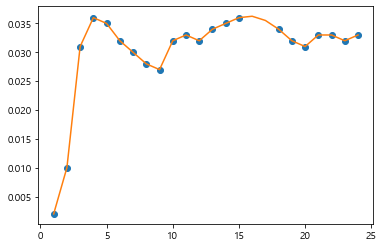

In [210]:
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

##### interpolate로 실제로 보간하기
- 특정 일자 내에서 연속적으로 나타나지 않는 

In [276]:
data_상대동.isnull().sum()

PM10_1시간     55
PM25_1시간     57
오존_1시간       18
이산화질소_1시간    18
일산화탄소_1시간    18
아황산가스_1시간    18
지점            0
년월일           0
시             0
dtype: int64

In [277]:
data_상대동[data_상대동["오존_1시간"].isnull()]["년월일"].value_counts()

2022-02-03    3
2022-01-17    3
2022-02-10    2
2022-03-07    2
2021-12-10    2
2022-03-23    2
2022-02-17    2
2022-01-11    2
Name: 년월일, dtype: int64

In [278]:
data_상대동[data_상대동["오존_1시간"].isnull()].head(3)

,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,지점,년월일,시
351,NaN,NaN,NaN,NaN,NaN,NaN,상대동,2021-12-10,15
352,NaN,NaN,NaN,NaN,NaN,NaN,상대동,2021-12-10,16
1120,NaN,NaN,NaN,NaN,NaN,NaN,상대동,2022-01-11,16


In [279]:
# data_상대동_nonull : null값을 채울 데이터
data_상대동_nonull = data_상대동.copy()

In [283]:
null_date_1 = data_상대동[data_상대동["오존_1시간"].isnull()]["년월일"].value_counts().index
print(null_date_1)

DatetimeIndex(['2022-02-03', '2022-01-17', '2022-02-10', '2022-03-07',
               '2021-12-10', '2022-03-23', '2022-02-17', '2022-01-11'],
              dtype='datetime64[ns]', freq=None)


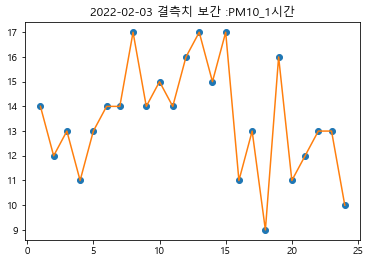

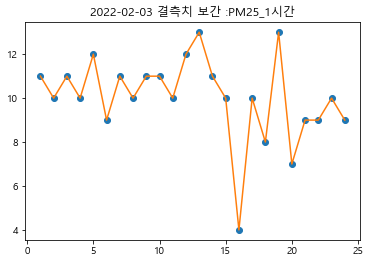

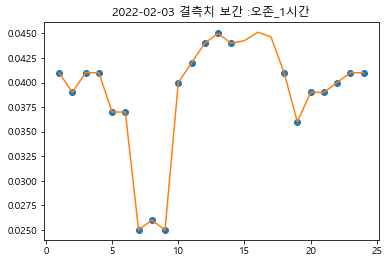

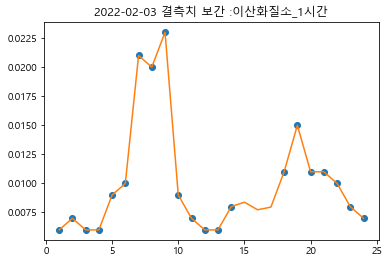

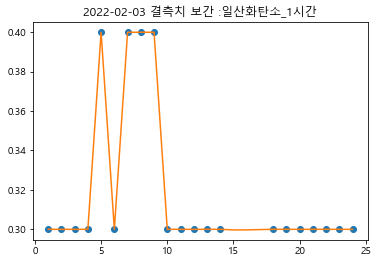

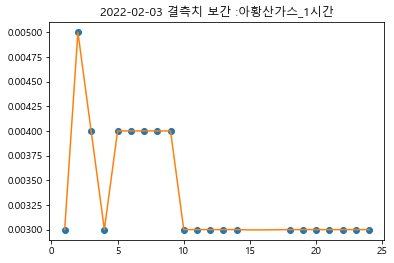

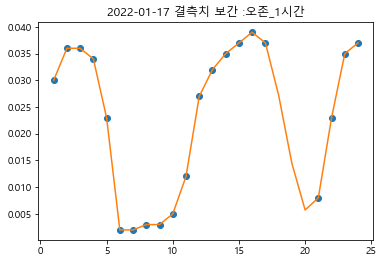

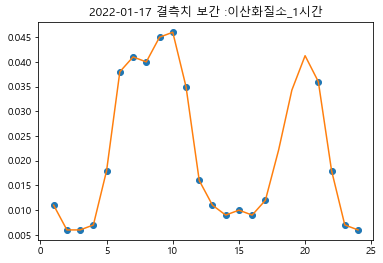

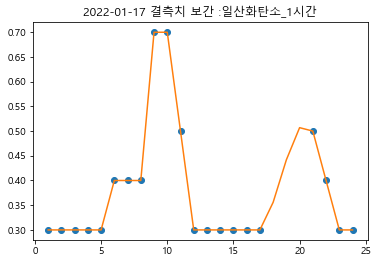

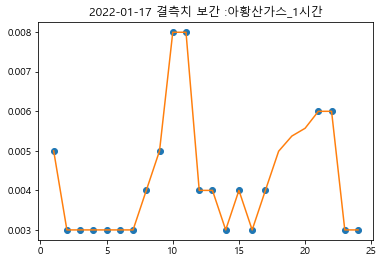

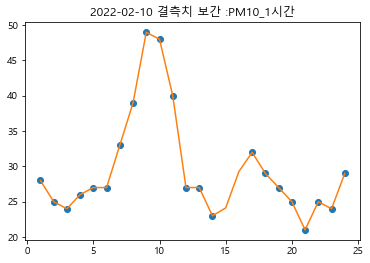

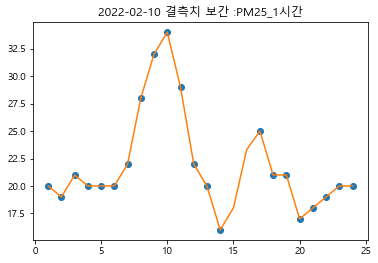

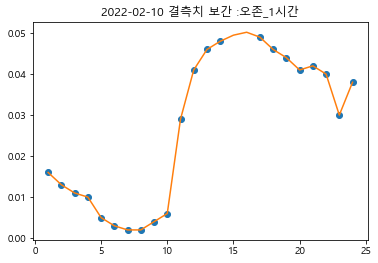

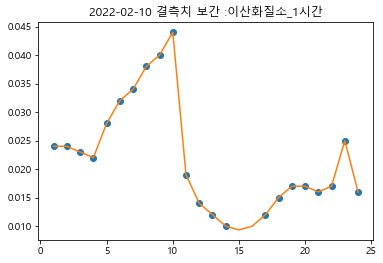

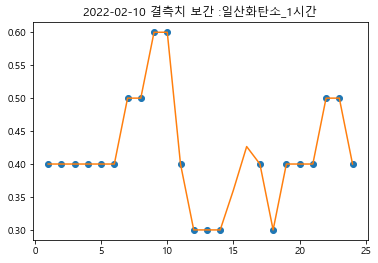

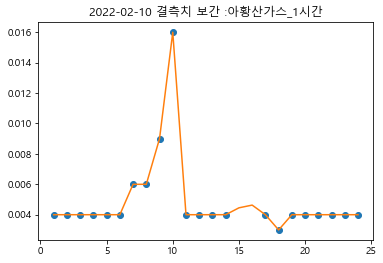

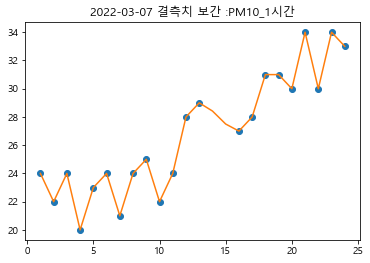

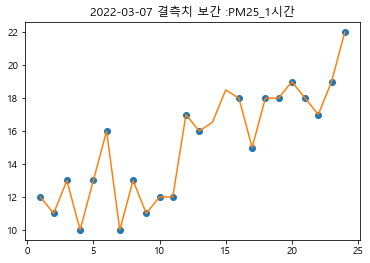

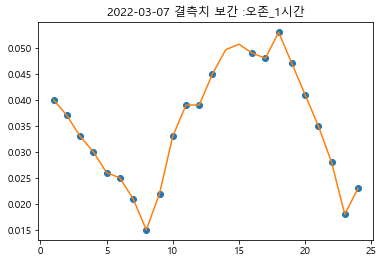

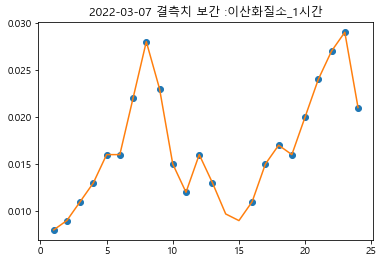

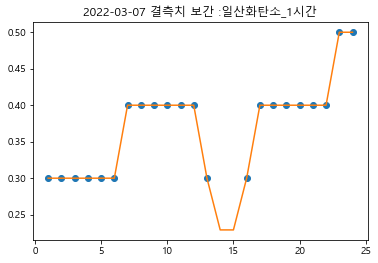

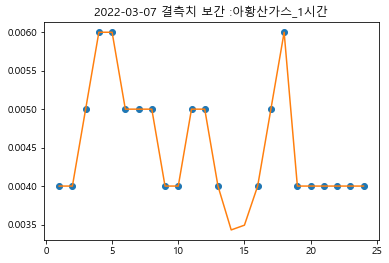

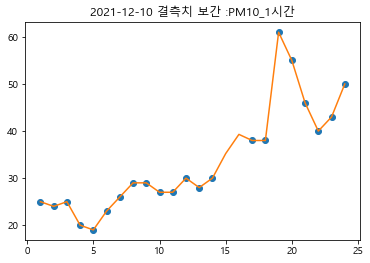

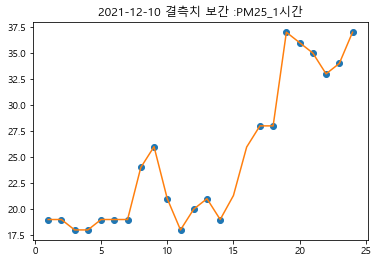

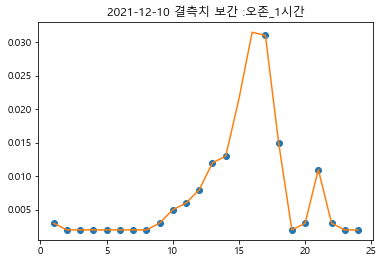

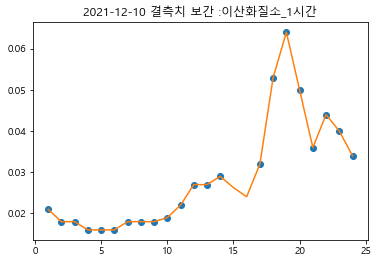

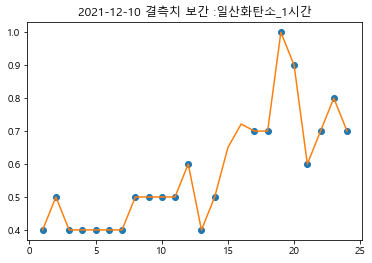

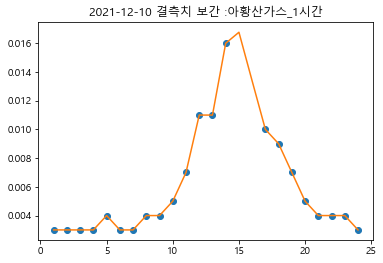

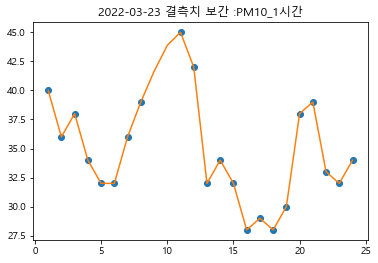

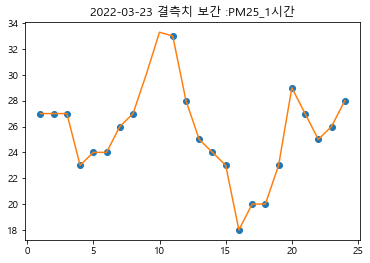

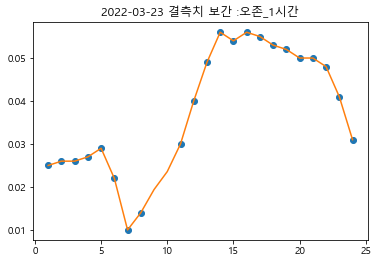

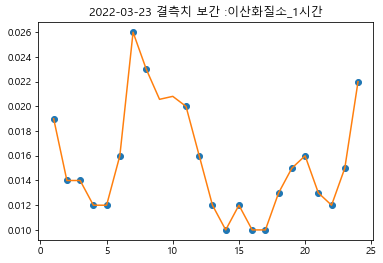

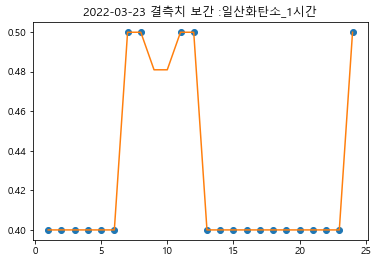

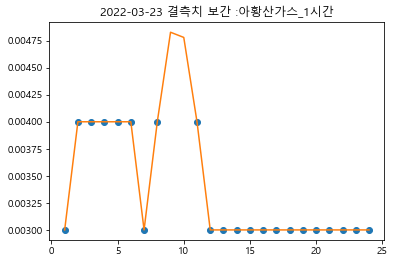

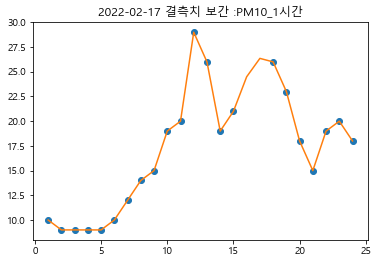

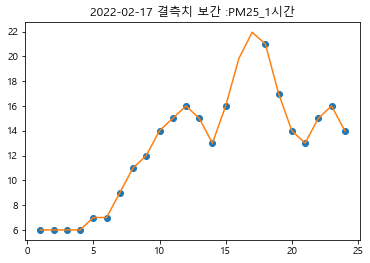

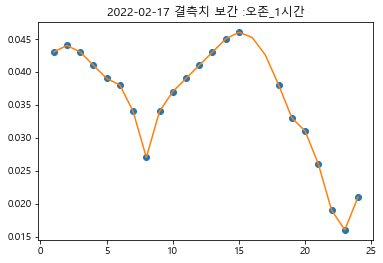

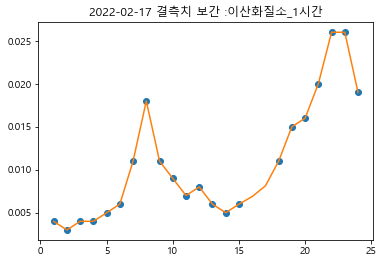

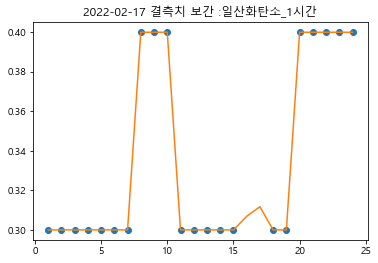

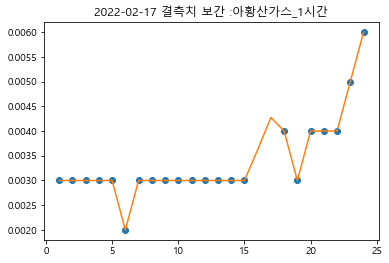

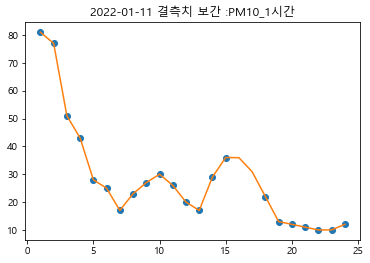

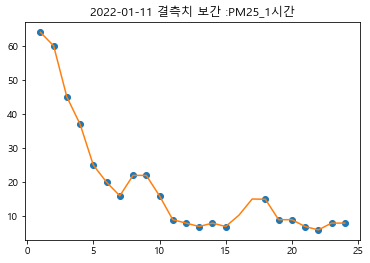

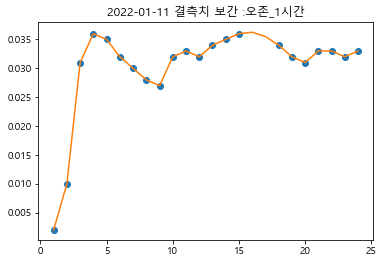

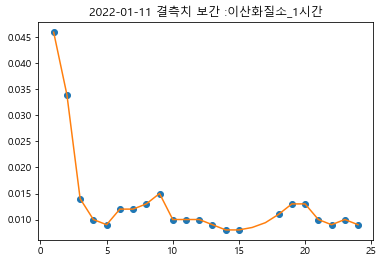

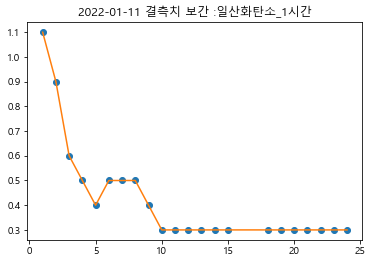

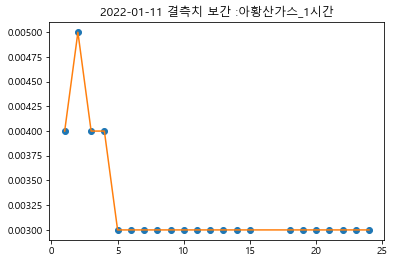

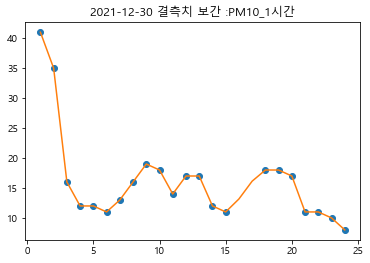

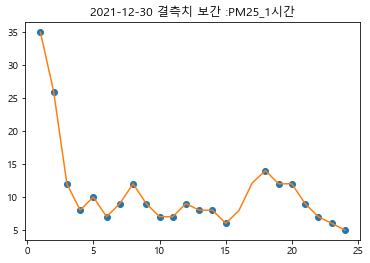

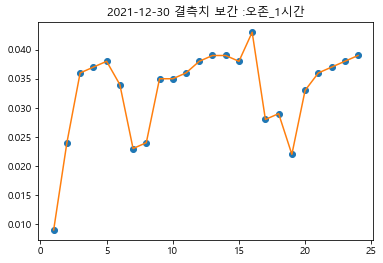

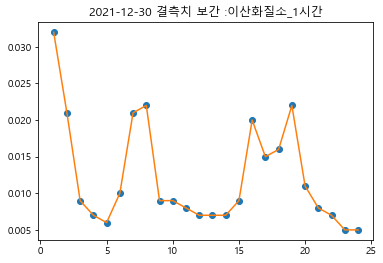

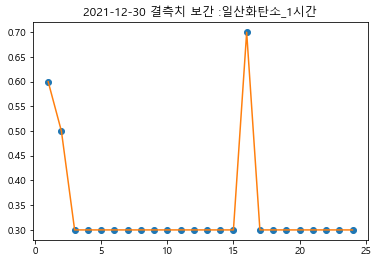

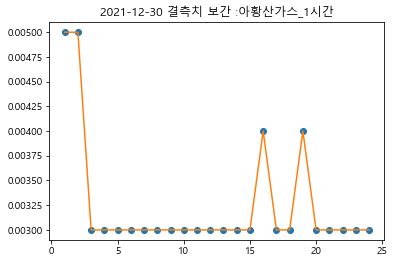

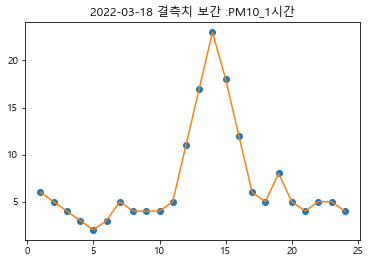

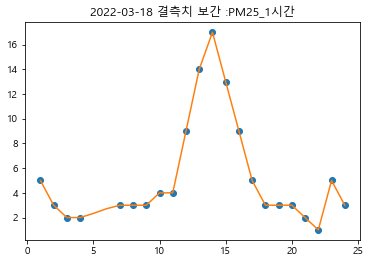

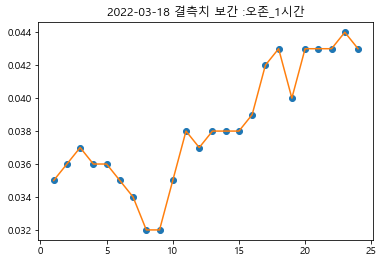

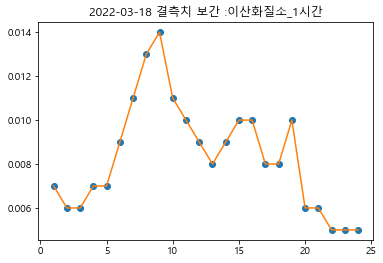

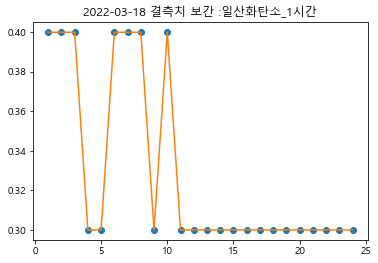

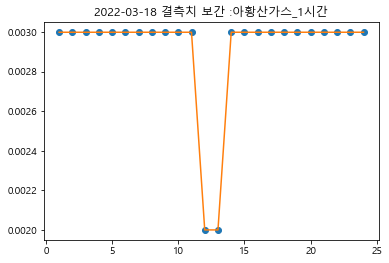

In [284]:
for date in ['2022-02-03', '2022-01-17', '2022-02-10', '2022-03-07',
               '2021-12-10', '2022-03-23', '2022-02-17', '2022-01-11',"2021-12-30","2022-03-18"]:
    
    df = data_상대동[data_상대동["년월일"] == date]

    for col in ["PM10_1시간","PM25_1시간","오존_1시간","이산화질소_1시간","일산화탄소_1시간","아황산가스_1시간"]:
        
        nonull_df = df[df[col].notnull()]
        
        x = nonull_df.set_index("시").index
        y = nonull_df[col]
        
        if len(x) > 20:
            # 결측이 4개 이상이면 interpolate 사용안함
        
            f = interpolate.interp1d(x, y,kind='cubic')

            xnew = [i for i in range(1,25)]
            ynew = f(xnew)

            df[col] = ynew

            # 그림 그리기
            plt.plot(x, y, 'o', xnew, ynew, '-')
            plt.title(str(date) + " 결측치 보간 :"+ str(col))
            plt.show()


            for k in df.index:
                data_상대동_nonull.loc[k,col] = df.loc[k,col]
        else:
            pass

In [285]:
data_상대동_nonull.isnull().sum()

PM10_1시간     41
PM25_1시간     41
오존_1시간        0
이산화질소_1시간     0
일산화탄소_1시간     0
아황산가스_1시간     0
지점            0
년월일           0
시             0
dtype: int64

In [292]:
data_상대동_nonull[data_상대동_nonull["PM25_1시간"].isnull()]["년월일"].value_counts()

2022-01-18    24
2022-01-19    10
2022-01-17     7
Name: 년월일, dtype: int64

### 미세먼지 데이터 결측치 처리
- 나머지 데이터로 예측하기
- 결측치 개수에 따른 처리 : https://m.blog.naver.com/youji4ever/221712578078
- df.dropna(tresh=2)

지역간 상관관계 확인하기

- data_대안동
- data_상봉동
- data_상대동

In [139]:
data_상봉동_copy = data_상봉동.copy()


data_상봉동_copy.columns = ["PM10_상봉동","PM25_상봉동","오존_상봉동",
                         "이산화질소_상봉동","일산화탄소_상봉동","아황산가스_상봉동","지점","년월일","시"]

data_대안동_copy = data_대안동.copy()


data_대안동_copy.columns = ["PM10_대안동","PM25_대안동","오존_대안동",
                         "이산화질소_대안동","일산화탄소_대안동","아황산가스_대안동","지점","년월일","시"]

data_상대동_copy = data_상대동.copy()


data_상대동_copy.columns = ["PM10_상대동","PM25_상대동","오존_상대동",
                         "이산화질소_상대동","일산화탄소_상대동","아황산가스_상대동","지점","년월일","시"]

data_상대동_copy.drop(["년월일","시","지점"],axis=1,inplace=True)
data_대안동_copy.drop(["년월일","시","지점"],axis=1,inplace=True)
data_상봉동_copy.drop(["년월일","시","지점"],axis=1,inplace=True)

In [140]:
data_concat_copy = pd.concat([data_상대동_copy,data_상봉동_copy,data_대안동_copy],axis=1)

data_concat_copy["년월일"] = data_상대동["년월일"]
data_concat_copy["시"] = data_상대동["시"]

In [143]:
data_concat_copy.head(3)

,PM10_상대동,PM25_상대동,오존_상대동,이산화질소_상대동,일산화탄소_상대동,아황산가스_상대동,PM10_상봉동,PM25_상봉동,오존_상봉동,이산화질소_상봉동,일산화탄소_상봉동,아황산가스_상봉동,PM10_대안동,PM25_대안동,오존_대안동,이산화질소_대안동,일산화탄소_대안동,아황산가스_대안동,년월일,시
0,38.0,26.0,0.015,0.021,0.4,0.003,28.0,10.0,0.003,0.035,0.5,0.004,39.0,11.0,0.011,0.027,0.4,0.003,2021-11-25,0
1,39.0,25.0,0.012,0.021,0.4,0.003,18.0,7.0,0.004,0.031,0.5,0.004,40.0,15.0,0.011,0.024,0.4,0.003,2021-11-26,1
2,36.0,23.0,0.008,0.023,0.4,0.003,22.0,5.0,0.003,0.029,0.5,0.004,41.0,17.0,0.005,0.028,0.4,0.003,2021-11-26,2


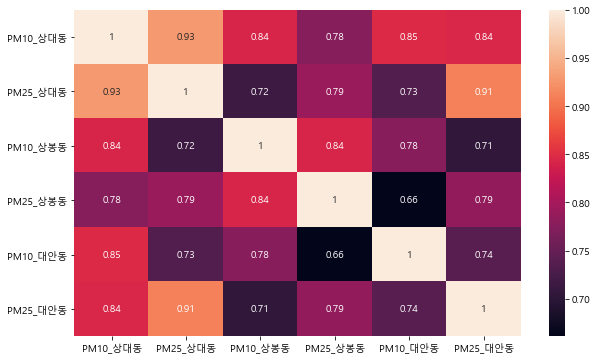

In [289]:
corr_df = data_concat_copy[["PM10_상대동","PM25_상대동","PM10_상봉동","PM25_상봉동",
                          "PM10_대안동","PM25_대안동"]].corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(corr_df, annot=True)
plt.show()

# 상관관계가 기존의 열들 사이에서는 그리 높지 않게 나타남. 0.9 넘는 것 없음

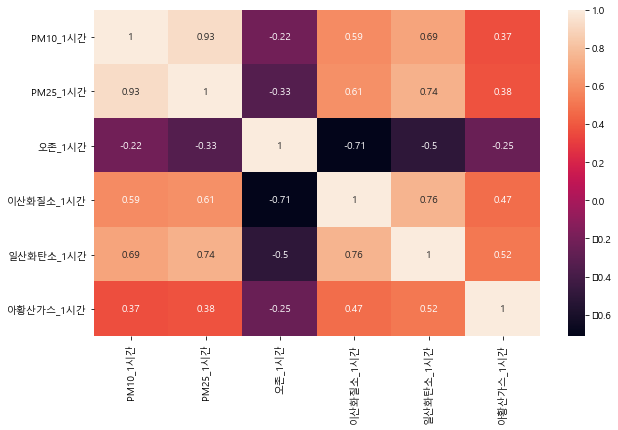

In [21]:
corr_df = data_상대동.drop(['년월일','시', '지점'],axis=1).corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(corr_df, annot=True)
plt.show()

# 상관관계가 기존의 열들 사이에서는 그리 높지 않게 나타남. 0.9 넘는 것 없음

In [25]:
data_상대동.to_csv("test.csv",encoding="utf-8-sig",index=False)

### 제어조건을 기반으로 한 파생변수 생성

1. 차열스크린
  - 광도조절(800w/m²=100%개방, 1000w/m²=70%개방, 1100W/m²=30%개방, 1200W/m²=0%개방)
  - 온도조절(23도=100%개방, 25도=60%개방, 26도=0개방) 
2. 차광스크린
 * 주간(일출3시간후~ 일몰3시간후) 
  - 광도조절(1000W/m² = 100%개방, 1400W/m²=80%개방, 15 00W/m²=30%개방, 1600W/m²=0%개방)
 * 야간(일몰3시간후~일출1시간후)
  - 온도조절(내부온도  27도 이상시 100%개방)
3. 에너지스크린
  - 겨울철 난방에너지 저감을 위한 보온을 목적으로 일몰 1시간 30분전 닫음
4. 팬코일
  - 난방온도 이하시 열공급을 위해 가동(에너지소비량과 밀접한 영향이 있음)
5. 천창 및 배기팬
  - 온실내부가 환기온도 이상으로 상승시 동시 작동(천창개방, 배기팬 작동)
6. 유동팬
  - 내부공기를 적절히 혼합시키기위해 작동

1. 차광스크린에 대한 광도 구간 설정
- 구간 1 : 1000 ~ 1400
- 구간 2 : 1400 ~ 1500
- 구간 3 : 1500 ~ 1600

1.1. 차광스크린에 대한 온도 구간 설정
- 내부온도 27 이상 : 1
- 내부온도 27 미만 : 0

2. 일몰, 일출시간에 대한 파생변수
- 주간 : 일출 3시간후 ~ 일몰 3시간후
- 야간 : 일몰 3시간후 ~ 일출 1시간후
- 나머지는 그 외...
- 일몰 1시간 30분 전과 후

3. 차열스크린에 대한 광도 구간 설정
- 구간 1 : ~ 800
- 구간 2 : 800 ~ 1000
- 구간 3 : 1000 ~ 1100
- 구간 4 : 1100 ~ 1200
- 구간 5 : 1200 ~

4. 차열스크린에 대한 온도 구간 설정
- 구간 1 : ~ 23
- 구간 2 : 23 ~ 25
- 구간 3 : 25 ~ 26
- 구간 4 : 26 ~

In [415]:
train_test.columns

Index(['시간', '년월일', '년도', '월', '일', '시', '분', '일사량(W/㎡)', '외기온(℃)', '외기습도(%)',
       '풍속(m/s)', '풍향(º)', '내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)',
       '에너지스크린(수평)', '에너지스크린(수직)', '배기팬', '천창', '유동팬', '팬코일 B동',
       '환기온도(천창 제어온도)', '난방온도(설정온도)', '열공급량(kWh)'],
      dtype='object')

In [416]:
train_test["차열스크린(수평)"].describe()

count    131053.000000
mean         41.644052
std          48.766469
min           0.000000
25%           0.000000
50%           0.000000
75%         100.000000
max         100.000000
Name: 차열스크린(수평), dtype: float64

#### 일출, 일몰 데이터 추가하기

In [48]:
sunrise = pd.read_csv("sunset_sunrise_data.csv")
sunrise.columns = ["년월일","일출시간","일몰시간"]

In [49]:
sunrise.head()

,년월일,일출시간,일몰시간
0,20211126,713,1717
1,20211127,714,1716
2,20211128,715,1716
3,20211129,716,1716
4,20211130,717,1716


In [50]:
from datetime import datetime
from datetime import timedelta

for col in sunrise.columns:
    sunrise[col] = sunrise[col].astype(str)
    
sunrise["년월일"] = sunrise["년월일"].apply(lambda x : datetime.strptime(x,'%Y%m%d'))

In [51]:
sunrise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   년월일     95 non-null     datetime64[ns]
 1   일출시간    95 non-null     object        
 2   일몰시간    95 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.4+ KB


In [52]:
sunrise["일출시간"] = sunrise["일출시간"].apply(lambda x : datetime.strptime(x,'%H%M'))
sunrise["일몰시간"] = sunrise["일몰시간"].apply(lambda x : datetime.strptime(x,'%H%M'))

In [53]:
sunrise["일출3시간후"] = sunrise["일출시간"].apply(lambda x : x + timedelta(hours=3))
sunrise["일출1시간후"] = sunrise["일출시간"].apply(lambda x : x + timedelta(hours=1))
sunrise["일몰3시간후"] = sunrise["일몰시간"].apply(lambda x : x + timedelta(hours=3))
sunrise["일몰1시간반전"] = sunrise["일몰시간"].apply(lambda x : x - timedelta(hours=1,minutes=30))

In [54]:
# 시간만 추출하기
sunrise["일몰시간"] = sunrise["일몰시간"].dt.time
sunrise["일출시간"] = sunrise["일출시간"].dt.time

sunrise["일출3시간후"] = sunrise["일출3시간후"].dt.time
sunrise["일출1시간후"] = sunrise["일출1시간후"].dt.time
sunrise["일몰3시간후"] = sunrise["일몰3시간후"].dt.time
sunrise["일몰1시간반전"] = sunrise["일몰1시간반전"].dt.time

In [55]:
#from datetime import timedelta
#sunrise["일출시간"] = sunrise["일출시간"].apply(lambda x : timedelta(hours=int(x[0]), minutes=int(x[1:3])))
#sunrise["일몰시간"] = sunrise["일몰시간"].apply(lambda x : timedelta(hours=int(x[:2]), minutes=int(x[2:4])))

# 야간(일몰3시간후~일출1시간후)
# 주간(일출3시간후~ 일몰3시간후)

In [56]:
sunrise.head(3)

,년월일,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전
0,2021-11-26,07:13:00,17:17:00,10:13:00,08:13:00,20:17:00,15:47:00
1,2021-11-27,07:14:00,17:16:00,10:14:00,08:14:00,20:16:00,15:46:00
2,2021-11-28,07:15:00,17:16:00,10:15:00,08:15:00,20:16:00,15:46:00


#### datetime이 아닌 int 자체로 다뤄보기

In [57]:
def datetime_str_to_int(x):
    x_lst = x.split(":")
    
    hour = int(x_lst[0])
    minute = int(x_lst[1])
    
    return hour * 100 + minute

In [58]:
sunrise["일출시간"] = sunrise["일출시간"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))
sunrise["일몰시간"] = sunrise["일몰시간"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))

sunrise["일출3시간후"] = sunrise["일출3시간후"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))
sunrise["일출1시간후"] = sunrise["일출1시간후"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))
sunrise["일몰3시간후"] = sunrise["일몰3시간후"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))
sunrise["일몰1시간반전"] = sunrise["일몰1시간반전"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))

In [59]:
sunrise.head(3)

,년월일,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전
0,2021-11-26,713,1717,1013,813,2017,1547
1,2021-11-27,714,1716,1014,814,2016,1546
2,2021-11-28,715,1716,1015,815,2016,1546


### 데이터 연결하고 연속형 변수의 구간 설정하기
- https://hleecaster.com/pandas-pd-cut/

### 광도에 대한 파생변수
- 광도와 일사량이 일치하는 변수가 아닌 것으로 판단됨
- 광도 : 빛의 세기
- 광량 = 일사량
- https://m.cafe.daum.net/departlife/NvZ3/6?q=D_SgkccTp8KnI0&
- 차열스크린_광도조절, 차광스크린_광도조절 함수 수정하기

In [60]:
train_test.columns

Index(['시간', '년월일', '년도', '월', '일', '시', '분', '일사량(W/㎡)', '외기온(℃)', '외기습도(%)',
       '풍속(m/s)', '풍향(º)', '내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)',
       '에너지스크린(수평)', '에너지스크린(수직)', '배기팬', '천창', '유동팬', '팬코일 B동',
       '환기온도(천창 제어온도)', '난방온도(설정온도)', '열공급량(kWh)'],
      dtype='object')

#### 차광스크린에 대한 온도 구간

In [61]:
def 차광스크린_개방(x):
    if x >= 27:
        return 1
    else:
        return 0

In [62]:
train_test["차광스크린_개방"] = train_test["내부 온도"].apply(lambda x : 차광스크린_개방(x))

#### 차광스크린에 대한 광도 구간

In [63]:
def 차광스크린_광도조절(x):
    if x < 1000:
        return "1000미만"
    
    elif 1000 <= x < 1400:
        return "1000이상1400미만"
    
    elif 1400 <= x < 1500:
        return "1400이상1500미만"
    
    elif 1500 <= x < 1600:
        return "1500이상1600미만"

    elif x >= 1600:
        return "1600이상"

'def 차광스크린_광도조절(x):\n    if x < 1000:\n        return "1000미만"\n    \n    elif x >= 1000 & x < 1400:\n        return "1000이상1400미만"\n    \n    elif x >= 1400 & x < 1500:\n        return "1400이상1500미만"\n    \n    elif x >= 1500 & x < 1600:\n        return "1500이상1600미만"\n\n    elif x >= 1600:\n        return "1600이상"\n'

In [64]:
def 차광스크린_개방조절(x):
    # x 값은 차광스크린 개방 %
    
    if x == 100:
        return "100%개방"
    
    elif 80 <= x < 100: 
        return "80%~100%개방"
    
    elif 30 <= x < 80:
        return "30%~80%개방"
    
    elif 0 <= x < 30:
        return "0%~30%개방"

In [65]:
train_test["차광스크린_개방조절"] = train_test["차광스크린(수평)"].apply(lambda x : 차광스크린_개방조절(x))

#### 차열스크린에 대한 온도 구간 설정

In [66]:
def 차열스크린_온도조절(x):
    if x < 23:
        return "23도미만"
    
    elif 23 <= x < 25:
        return "23도~25도"
    
    elif 25 <= x < 26:
        return "25도~26도"
    
    elif x >= 26:
        return "26도이상"

In [67]:
train_test["차열스크린_온도조절"] = train_test["내부 온도"].apply(lambda x : 차열스크린_온도조절(x))

#### 차열스크린에 대한 광도 구간 설정

In [91]:
def 차열스크린_광도조절(x):
    if x < 800:
        return "800미만"
    
    elif 800 <= x < 1000:
        return "800~1000"
    
    elif 1000 <= x < 1100:
        return "1000~1100"
    
    elif 1100 <= x < 1200:
        return "1100~1200"
    
    elif x >= 1200:
        return "1200이상"

In [ ]:
train_test["차열스크린_광도조절"] = train_test["차열스크린(수평)"].apply(lambda x : 차열스크린_광도조절(x))

In [70]:
def 차열스크린_개방조절(x):
    # x 값은 차열스크린 개방 %
    
    if x == 100:
        return "100%개방"
    
    elif 70 <= x < 100: 
        return "70%~100%개방"
    
    elif 30 <= x < 70:
        return "30%~70%개방"
    
    elif 0 <= x < 30:
        return "0%~30%개방"

In [71]:
train_test["차열스크린_개방조절"] = train_test["차열스크린(수평)"].apply(lambda x : 차열스크린_개방조절(x))

#### 년월일로 연결하기
- 년-월-일 Datetime 객체로 연결하기

In [522]:
train_test["년도"] = train_test["년도"].astype(str)
train_test["월"] = train_test["월"].astype(str)
train_test["일"] = train_test["일"].astype(str)

In [523]:
from datetime import datetime
train_test["년월일"] = train_test["년도"] + "-" + train_test["월"] + "-" + train_test["일"]

In [524]:
train_test["년월일"] = train_test["년월일"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))

In [525]:
train_test_sunrise = pd.merge(train_test,sunrise,on="년월일",how="left")

In [526]:
train_test_sunrise.head(3)

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,차광스크린_개방,차광스크린_광도조절,차열스크린_온도조절,차열스크린_광도조절,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전
0,2021-11-26 00:00:00,2021-11-26,2021,11,26,0,0,-2.7,5.8,67,...,0,0%~30%개방,23도미만,0%~30%개방,713,1717,1013,813,2017,1547
1,2021-11-26 00:01:00,2021-11-26,2021,11,26,0,1,-2.9,5.8,67,...,0,0%~30%개방,23도미만,0%~30%개방,713,1717,1013,813,2017,1547
2,2021-11-26 00:02:00,2021-11-26,2021,11,26,0,2,-3.0,5.7,67,...,0,0%~30%개방,23도미만,0%~30%개방,713,1717,1013,813,2017,1547


현재 시간 추출해서 int로 비교하기

2. 일몰, 일출시간에 대한 파생변수
- 주간 : 일출 3시간후 ~ 일몰 3시간후
- 야간 : 일몰 3시간후 ~ 일출 1시간후
- 나머지는 그 외...
- 일몰 1시간 30분 전과 후

In [529]:
# dt로 시간만 추출하기
# 일몰, 일출시간과 비교
train_test_sunrise["시간추출"] = train_test_sunrise["시간"].dt.time

# int로 변환
train_test_sunrise["시간추출"] = train_test_sunrise["시간추출"].apply(lambda x : datetime_str_to_int(x.strftime('%H:%M:%S')))

In [541]:
def 시간범주_생성(x):
    
    # 데이터프레임 행 하나씩 입력이 된다
    if x["일출3시간후"] <= x["시간추출"] < x["일몰3시간후"]:
        return "주간"
    
    elif x["일몰3시간후"] <= x["시간추출"] < 2400:
        return "야간"
    
    elif 0  <= x["시간추출"] < x["일출1시간후"]:
        return "야간"
    
    elif x["일출1시간후"] <= x["시간추출"] < x["일출3시간후"]:
        return "그외"

In [544]:
시간범주_생성_lst = []

for idx,data in train_test_sunrise.iterrows():
    시간범주_생성_lst.append(시간범주_생성(data))
    
train_test_sunrise["시간범주"] = 시간범주_생성_lst

일몰전후

In [552]:
def 일몰전후(x):
    # 데이터프레임 행 하나씩 입력이 된다
    
    if 0 <= x["시간추출"] < x["일출시간"]:
        return "일몰1시간반_후"
    
    elif x["일출시간"] <= x["시간추출"] < x["일몰1시간반전"]:
        return "일몰1시간반_전"
    
    elif x["일몰1시간반전"] <= x["시간추출"] <= 2400:
        return "일몰1시간반_후"

In [554]:
일몰전후_생성_lst = []

for idx,data in train_test_sunrise.iterrows():
    일몰전후_생성_lst.append(일몰전후(data))
    
train_test_sunrise["일몰전후"] = 일몰전후_생성_lst

In [555]:
train_test_sunrise.head(3)

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,차열스크린_광도조절,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,시간추출,시간범주,일몰전후
0,2021-11-26 00:00:00,2021-11-26,2021,11,26,0,0,-2.7,5.8,67,...,0%~30%개방,713,1717,1013,813,2017,1547,0,야간,일몰1시간반_후
1,2021-11-26 00:01:00,2021-11-26,2021,11,26,0,1,-2.9,5.8,67,...,0%~30%개방,713,1717,1013,813,2017,1547,1,야간,일몰1시간반_후
2,2021-11-26 00:02:00,2021-11-26,2021,11,26,0,2,-3.0,5.7,67,...,0%~30%개방,713,1717,1013,813,2017,1547,2,야간,일몰1시간반_후


### 미세먼지 데이터와 연결하기
- train_test_sunrise : 일출일몰 + 기상데이터
- data_상대동 : 상대동 미세먼지 데이터
- train_test_sunrise_air : 일출일몰 + 기상 + 미세먼지

미세먼지 예보기준
- https://easylaw.go.kr/CSP/CnpClsMain.laf?popMenu=ov&csmSeq=1346&ccfNo=2&cciNo=1&cnpClsNo=1

오존등급
- https://www.changwon.go.kr/depart/contents.do?mId=1003110200

대기등급
- https://www.airkorea.or.kr/web

In [610]:
#초미세먼지 예보기준(㎍/㎥) : 좋음(1~15), 보통(16~35), 나쁨(36~75), 매우나쁨(76이상)

In [597]:
train_test_sunrise_air = pd.merge(train_test_sunrise,data_상대동,on=["년월일","시"],how="left")

In [623]:
train_test_sunrise_air.head()

,시간,년월일,년도,월,일,시,분,일사량(W/㎡),외기온(℃),외기습도(%),...,PM25_1시간,오존등급,오존_1시간,이산화질소등급,이산화질소_1시간,일산화탄소등급,일산화탄소_1시간,아황산가스등급,아황산가스_1시간,지점
0,2021-11-26 00:00:00,2021-11-26,2021,11,26,0,0,-2.7,5.8,67,...,22.0,좋음,0.003,좋음,0.028,좋음,0.4,좋음,0.003,상대동
1,2021-11-26 00:01:00,2021-11-26,2021,11,26,0,1,-2.9,5.8,67,...,22.0,좋음,0.003,좋음,0.028,좋음,0.4,좋음,0.003,상대동
2,2021-11-26 00:02:00,2021-11-26,2021,11,26,0,2,-3.0,5.7,67,...,22.0,좋음,0.003,좋음,0.028,좋음,0.4,좋음,0.003,상대동
3,2021-11-26 00:03:00,2021-11-26,2021,11,26,0,3,-3.0,5.7,67,...,22.0,좋음,0.003,좋음,0.028,좋음,0.4,좋음,0.003,상대동
4,2021-11-26 00:04:00,2021-11-26,2021,11,26,0,4,-2.8,5.7,67,...,22.0,좋음,0.003,좋음,0.028,좋음,0.4,좋음,0.003,상대동
